## Applications of Machine Learning in Human Resources Management
## Multi-classification Models

As described in my earlier notebook, we will be building two multi-classification models:
1. A multi-classification model with an employee's performance ('PerformanceRank_Current') as a target variable, where the focus is on the interpretability of the model (as opposed to accuracy) to understand the key drivers of performance to re-empower the HR team to have more effective talent conversations with the workforce and reduce reliance on managers for appraisals, and
2. A multi-classification model with an employee's attrition risk ('AttritionRisk') as a target variable, to predict an employee's risk of attrition for appropriate intervention from HR to retain top-talent within the firm

In [1]:
#basic libraries
import pandas as pd
import numpy as np
import math
import statistics
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint #pretty printing

#define graph settings
sns.set(style = "whitegrid")

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#machine learning packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as sklm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score

%matplotlib inline

## <mark> Initialize the dataset

In [2]:
df = pd.read_csv("dummy_HR_data_ML.csv")
pd.set_option('display.max_columns', None)
df.head()

,emp_id,BusinessUnit_Primary,Function,Country,Pay_Grade,EmpDuration_Company,EmpDuration_Position,Gender,Age_Decade,Race,Graduate,AttritionRisk,ForeignCountry,Position_>3Y,Position_>5Y,Seniority,JobTitleAgg,PromoEligibility,TargetedRoleIdentified,PerformanceRank_Current,PerformanceRank_LastYear,PotentialRank_Current,PotentialRank_LastYear,ChangeInPerformanceRank,ChangeInPotentialRank
0,1,BU_P1,Others,GL,1,15.0,12.5,Female,5,Hispano,No,1,0,1,1,1,Admin Assistant,0,0,2,2,2,2,0,0
1,2,BU_P1,Others,GL,1,15.0,12.5,Female,4,British,No,1,0,1,1,1,Admin Assistant,0,0,2,2,2,2,0,0
2,3,BU_P1,Sales & Marketing,GL,5,12.5,12.5,Male,6,British,No,1,1,1,1,3,Manager,0,0,2,2,2,2,0,0
3,4,BU_P1,Sales & Marketing,GL,3,2.0,2.0,Female,4,Chinese,No,1,1,0,0,2,Adviser,0,0,3,3,3,3,0,0
4,5,BU_P1,Sales & Marketing,CA,2,15.0,2.0,Female,5,Scottish,No,1,0,0,0,1,Analyst,0,0,3,3,3,3,0,0


In [3]:
#quick glimpse of the shape of the dataframe and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   emp_id                    943 non-null    int64  
 1   BusinessUnit_Primary      943 non-null    object 
 2   Function                  943 non-null    object 
 3   Country                   943 non-null    object 
 4   Pay_Grade                 943 non-null    int64  
 5   EmpDuration_Company       943 non-null    float64
 6   EmpDuration_Position      943 non-null    float64
 7   Gender                    943 non-null    object 
 8   Age_Decade                943 non-null    int64  
 9   Race                      943 non-null    object 
 10  Graduate                  943 non-null    object 
 11  AttritionRisk             943 non-null    int64  
 12  ForeignCountry            943 non-null    int64  
 13  Position_>3Y              943 non-null    int64  
 14  Position_>

In [4]:
#quick NaN check
df.isna().sum()

emp_id                      0
BusinessUnit_Primary        0
Function                    0
Country                     0
Pay_Grade                   0
EmpDuration_Company         0
EmpDuration_Position        0
Gender                      0
Age_Decade                  0
Race                        0
Graduate                    0
AttritionRisk               0
ForeignCountry              0
Position_>3Y                0
Position_>5Y                0
Seniority                   0
JobTitleAgg                 0
PromoEligibility            0
TargetedRoleIdentified      0
PerformanceRank_Current     0
PerformanceRank_LastYear    0
PotentialRank_Current       0
PotentialRank_LastYear      0
ChangeInPerformanceRank     0
ChangeInPotentialRank       0
dtype: int64

In [5]:
#drop emp_id as it is an identifier, and we will only require it during clustering
df.drop(['emp_id'], axis = 1, inplace = True)

## <mark> Initial Feature Selection 

Rather than to throw all features as an input into the classifier model, we will utilize a simple statistical test to narrow the list of features. As mentioned before, as our features are categorical, we will use a chi-squared statistic to determine dependence of our features vs. target, where:

\begin{equation}H_{0}: Feature\ and\ Target\ are\ independent\\ H_{1}: Feature\ and\ Target\ are\ dependent\end{equation}

In [6]:
#creating a chi2 test function
def chi2_test(target, features):
    #define an empty list to populate with independent features from the test
    independent = []
    
    for col in features:
        #creating a contingency table of features vs. target
        contingency_table = pd.crosstab(df[target], df[col])

        #defining outputs from function "chi2_contingency"
        stat, p, dof, expected = chi2_contingency(contingency_table)
        
        print(col + ":") #print the feature name
        print("dof = %d" % dof) #print the degrees of freedom for the chi2 test

        #interpret chi2 test-statistic
        prob = 0.95
        critical = chi2.ppf(prob, dof)
        print("Approach 1: Interpreting the Chi2 test statistic\nProbability = %.3f, Critical = %.3f, Chi2 = %.3f" % (prob, critical, stat))
        if abs(stat) >= critical:
            print("Dependent (reject H0)\n")
        else:
            print("Independent (fail to reject H0)\n")

        #interpret p-value
        alpha = 1 - prob
        print("Approach 2: Interpreting the p-value\nSignificance = %.3f, p = %.3f" % (alpha, p))
        if p <= alpha:
            print("Dependent (reject H0)\n")
            print("-" * 30)
        else:
            print("Independent(fail to reject H0)\n")
            independent.append(col)
            print("-" * 30)
    print("List of Independent Features vs. Target(%s):" % target)
    print(independent) #print the list of independent features from the test
    
    return independent

#### Chi2 test of features vs. 'PerformanceRank_Current' as target variable
As our analytical objective is the understand the drivers of an employee's performance, we will remove related features to 'PerformanceRank_Current' namely: 
- 'PerformanceRank_LastYear': as we are interested to identify drivers of performance, we will drop an employee's previous year performance as a feature. Furthermore, we will capture the change in performance with 'ChangeInPerformanceRank'
- 'PotentialRank_Current' and 'PotentialRank_LastYear': As Performance and Potential are highly collinear, we will drop them. Similarly, 'ChangeInPotentialRank' will capture the change in an employee's potential

In [7]:
#define features and target for chi2_test
columns = df.columns.tolist()
drop = ['PerformanceRank_Current', 'PerformanceRank_LastYear', 
        'PotentialRank_Current', 'PotentialRank_LastYear']
features_pf = [ele for ele in columns if ele not in drop]

In [8]:
#running the chi2 test with 'PerformanceRank_Current' as target variable
independent = chi2_test('PerformanceRank_Current', features_pf)

BusinessUnit_Primary:
dof = 14
Approach 1: Interpreting the Chi2 test statistic
Probability = 0.950, Critical = 23.685, Chi2 = 34.008
Dependent (reject H0)

Approach 2: Interpreting the p-value
Significance = 0.050, p = 0.002
Dependent (reject H0)

------------------------------
Function:
dof = 4
Approach 1: Interpreting the Chi2 test statistic
Probability = 0.950, Critical = 9.488, Chi2 = 2.126
Independent (fail to reject H0)

Approach 2: Interpreting the p-value
Significance = 0.050, p = 0.713
Independent(fail to reject H0)

------------------------------
Country:
dof = 14
Approach 1: Interpreting the Chi2 test statistic
Probability = 0.950, Critical = 23.685, Chi2 = 44.140
Dependent (reject H0)

Approach 2: Interpreting the p-value
Significance = 0.050, p = 0.000
Dependent (reject H0)

------------------------------
Pay_Grade:
dof = 12
Approach 1: Interpreting the Chi2 test statistic
Probability = 0.950, Critical = 21.026, Chi2 = 14.099
Independent (fail to reject H0)

Approach 2: I

In [9]:
#getting the initial list of features for 'PerformanceRank_Current' from chi2_test
features_pf_initial = [ele for ele in features_pf if ele not in independent]
features_pf_initial

['BusinessUnit_Primary',
 'Country',
 'EmpDuration_Position',
 'AttritionRisk',
 'PromoEligibility',
 'TargetedRoleIdentified',
 'ChangeInPerformanceRank',
 'ChangeInPotentialRank']

#### Chi2 test of features vs. 'AttritionRisk' as target variable

In [10]:
#define features and target for chi2_test
columns = df.columns.tolist()
drop = ['AttritionRisk']
features_ar = [ele for ele in columns if ele not in drop]

In [11]:
#running the chi2 test with 'AttritionRisk' as target variable
independent = chi2_test('AttritionRisk', features_ar)

BusinessUnit_Primary:
dof = 14
Approach 1: Interpreting the Chi2 test statistic
Probability = 0.950, Critical = 23.685, Chi2 = 32.426
Dependent (reject H0)

Approach 2: Interpreting the p-value
Significance = 0.050, p = 0.003
Dependent (reject H0)

------------------------------
Function:
dof = 4
Approach 1: Interpreting the Chi2 test statistic
Probability = 0.950, Critical = 9.488, Chi2 = 5.139
Independent (fail to reject H0)

Approach 2: Interpreting the p-value
Significance = 0.050, p = 0.273
Independent(fail to reject H0)

------------------------------
Country:
dof = 14
Approach 1: Interpreting the Chi2 test statistic
Probability = 0.950, Critical = 23.685, Chi2 = 35.543
Dependent (reject H0)

Approach 2: Interpreting the p-value
Significance = 0.050, p = 0.001
Dependent (reject H0)

------------------------------
Pay_Grade:
dof = 12
Approach 1: Interpreting the Chi2 test statistic
Probability = 0.950, Critical = 21.026, Chi2 = 30.803
Dependent (reject H0)

Approach 2: Interpretin

In [12]:
#getting the initial list of features for 'PerformanceRank_Current' from chi2_test
features_ar_initial = [ele for ele in features_ar if ele not in independent]
features_ar_initial

['BusinessUnit_Primary',
 'Country',
 'Pay_Grade',
 'EmpDuration_Company',
 'EmpDuration_Position',
 'Gender',
 'Age_Decade',
 'Position_>5Y',
 'Seniority',
 'JobTitleAgg',
 'PromoEligibility',
 'PerformanceRank_Current',
 'PerformanceRank_LastYear',
 'PotentialRank_Current',
 'PotentialRank_LastYear',
 'ChangeInPerformanceRank',
 'ChangeInPotentialRank']

## <mark> Multi-Classifier with 'PerformanceRank_Current' as target

As mentioned previously, the objective of the model is on **interpretability** rather than accuracy - we are not attempting to create a model to predict an employee's performance but rather utilize the model to understand the key drivers of an employee's performance. We will still go through the workflow to improve the model's accuracy, but the focus should be on feature importance to understand the drivers of performance.
    
We will start first by observing the distribution of the target (label) with the code below:

In [13]:
#creating a plotting function for bar charts with count and % labels
def bar_count_perc(df, cols):
    for col in cols:
        fig, ax = plt.subplots(figsize = (12, 4))
        catp = sns.countplot(x = col, data = df)
        ax.set_title("# of Employees by: " + col + " (" + str(len(df[col])) + " observations)")
        ax.set_xlabel(col)
        ax.set_ylabel("# of Employees")
        ax.set_xticklabels(catp.get_xticklabels(), rotation = 90)
        
        #to get the count of observations above each bar
        count = [p.get_height() for p in catp.patches]
        patch = [p for p in catp.patches]
        num_of_cat = len(df[col].unique())
        for i in range(num_of_cat):
            x = patch[i].get_x() + patch[i].get_width() / 2 - 0.15 #x-position of label
            y = patch[i].get_y() + patch[i].get_height() + 0.15 #y-position of label
            catp.annotate(str(count[i]) + #to get the count of each bar
                          ", " + 
                          str(round(count[i]/len(df[col])*100, 2)) + #to get the % of each bar
                          "%", 
                          (x, y), size = 10)
    plt.show()

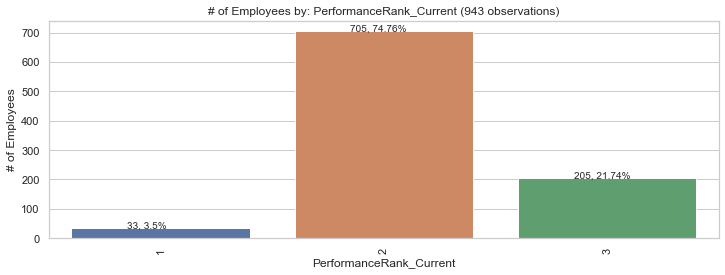

In [14]:
bar_count_perc(df,['PerformanceRank_Current'])

From the chart above, we can see an imbalance in our target towards "2" = "Medium" performance. We will account for this imbalance by utilizing 'class_weights = "balanced"' in our classifier algorithms.

#### Data preparation

In [15]:
#define X and Y for ML
x_pf = df[features_pf_initial]
y_pf = df['PerformanceRank_Current']

In [16]:
#perform One-Hot-Encoding for categorical, nominal features
#in this case, these are: 'BusinessUnit_Primary' and 'Country'
x_pf = pd.get_dummies(data = x_pf)
x_pf

,EmpDuration_Position,AttritionRisk,PromoEligibility,TargetedRoleIdentified,ChangeInPerformanceRank,ChangeInPotentialRank,BusinessUnit_Primary_BU_P1,BusinessUnit_Primary_BU_P2,BusinessUnit_Primary_BU_P3,BusinessUnit_Primary_BU_P4,BusinessUnit_Primary_BU_P5,BusinessUnit_Primary_BU_P6,BusinessUnit_Primary_BU_P7,BusinessUnit_Primary_BU_P8,Country_AU,Country_CA,Country_CN,Country_DE,Country_GL,Country_JP,Country_SG,Country_US
0,12.5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,12.5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,12.5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,1.0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
939,2.0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
940,2.0,2,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
941,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [17]:
#train-test-split the dataset, 30% test size
x_pf_train, x_pf_test, y_pf_train, y_pf_test = train_test_split(x_pf, y_pf, test_size = 0.3, random_state = 100)

#checking the shape of the train and test sets
print('x_pf_train shape: ', x_pf_train.shape)
print('y_pf_train shape: ', y_pf_train.shape)
print('x_pf_test shape: ', x_pf_test.shape)
print('y_pf_test shape: ', y_pf_test.shape)

x_pf_train shape:  (660, 22)
y_pf_train shape:  (660,)
x_pf_test shape:  (283, 22)
y_pf_test shape:  (283,)


#### Establishing a baseline: DecisionTree Classifier

In [18]:
#define the DecisionTree model
#as there is class imbalance in the label, we use 'class_weight = "balanced"'
dtree_pf = DecisionTreeClassifier(class_weight = "balanced", random_state = 100)

#train the model
dtree_pf = dtree_pf.fit(x_pf_train, y_pf_train)

In [19]:
#create a model scoring function
def score(model, color, test_features, test_labels): #color to set the color of the heatmap
    predictions = model.predict(test_features)
    
    #print the model's accuracy score
    print("Accuracy:", sklm.accuracy_score(test_labels, predictions))
    
    #create the confusion matrix
    confusion_matrix = pd.crosstab(test_labels, predictions, 
                                   rownames = ['Actual'], colnames = ['Predicted'],
                                   normalize = "columns")
    plt.figure(figsize = (12, 3))
    sns.heatmap(confusion_matrix, annot = True, fmt = "g", cmap = color, 
                linewidths = 1, linecolor = "lightgrey")
    
    #print the classification report
    print(classification_report(test_labels, predictions))

Accuracy: 0.558303886925795
              precision    recall  f1-score   support

           1       0.07      0.20      0.10        15
           2       0.81      0.60      0.68       210
           3       0.36      0.52      0.42        58

    accuracy                           0.56       283
   macro avg       0.41      0.44      0.40       283
weighted avg       0.68      0.56      0.60       283



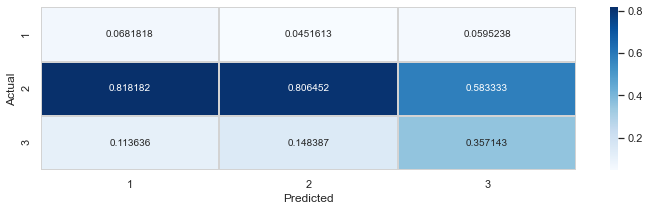

In [20]:
#score the DecisionTree model
score(dtree_pf, "Blues", x_pf_test, y_pf_test)

<mark> **Analysis:**
- **Baseline accuracy** of DecisionTree Classifier for 'PerformanceRank_Current' set at **56%**
- Weighted average **Precision** _(fraction of correctly classified label cases out of all cases classified with that label value, i.e. # of correctly classified cases for the label value divided by all cases in the **column**)_ at **68%**
- Weighted average **Recall** _(fraction of cases of a label value correctly classified out of all cases that actually have that label value, i.e. # of correctly classified cases for the label value divided by all cases in the **row**)_ at **56%**
- Weighted average **F1-Score** _(weighted average of Precision and Recall, i.e. a weighted metric for overall model performance)_ at **60%**

#### Using a more robust algorithm: RandomForest Classifier

Accuracy: 0.6289752650176679
              precision    recall  f1-score   support

           1       0.07      0.13      0.09        15
           2       0.79      0.72      0.76       210
           3       0.39      0.41      0.40        58

    accuracy                           0.63       283
   macro avg       0.42      0.42      0.42       283
weighted avg       0.67      0.63      0.65       283



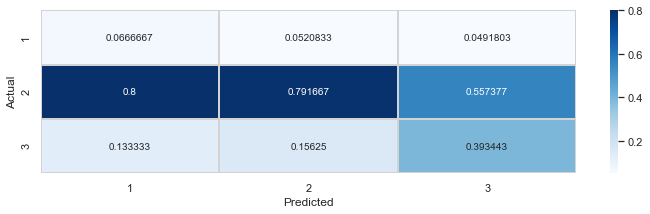

In [21]:
#defining the model
rf_pf = RandomForestClassifier(class_weight = "balanced", n_estimators = 100, random_state = 100, n_jobs = -1)

#training the model
rf_pf.fit(x_pf_train, y_pf_train)

#evaluate the model
score(rf_pf, "Blues", x_pf_test, y_pf_test)

<mark> **Analysis:**
- **Accuracy** of RandomForest Classifier for 'PerformanceRank_Current' improved to **63%** vs. DecisionTree Classifier's **56%**
- Weighted average **Precision** deproved slightly to **67%** from **68%**
- Weighted average **Recall** improved to **63%** from **56%**
- Weighted average **F1-Score** improved to **65%** from **60%**

#### Improving model performance: feature selection with 90% cumulative Gini Importance

In [22]:
#define function to get gini importance
def gini90(estimator, features_train):
    #get Gini Importance of features from the RandomForest model and sort by descending
    table = pd.DataFrame(estimator.feature_importances_, index = features_train.columns,
                         columns = ['Gini Importance']).sort_values('Gini Importance', ascending = False)
    
    #create a cumulative sum of importance
    table['Cumulative Gini Importances'] = np.cumsum(table)

    #create a column to store the feature name
    table['Feature'] = table.index
    table.reset_index(drop = True, inplace = True)

    #move feature name to front of the dataframe
    col_name = "Feature"
    first_col = table.pop(col_name)
    table.insert(0, col_name, first_col)

    return table

In [23]:
#call gini function and view table of importance
fi_pf = gini90(rf_pf, x_pf_train)

#find number of features for cumulative importance of 90%
#add 1 because Python is 0-indexed
print("Number of features for 90% Gini Importance: ",
      np.where(fi_pf["Cumulative Gini Importances"] > 0.90)[0][0] + 1)

fi_pf

Number of features for 90% Gini Importance:  14


,Feature,Gini Importance,Cumulative Gini Importances
0,EmpDuration_Position,0.188697,0.188697
1,AttritionRisk,0.159589,0.348286
2,PromoEligibility,0.119502,0.467789
3,TargetedRoleIdentified,0.083500,0.551288
4,BusinessUnit_Primary_BU_P6,0.054787,0.606075
5,Country_AU,0.048320,0.654395
6,Country_GL,0.045614,0.700009
7,Country_CA,0.035883,0.735892
8,Country_SG,0.035164,0.771056
9,BusinessUnit_Primary_BU_P8,0.030926,0.801983


In [24]:
#define plotting function for gini importance
def plot_gini(data):
    #create a combo chart
    fig, ax1 = plt.subplots(figsize = (12, 6))
    
    #bar plot creation
    ax1 = sns.barplot(x = "Feature", y = "Gini Importance", data = data, color = "b" )
    ax1.set_xlabel("Features")
    ax1.set_ylabel("Gini Importance")
    ax1.set_xticklabels(data.index, rotation = 90)
    ax1.tick_params(axis = "y")

    #specify we want to share the same x-axis
    ax2 = ax1.twinx()

    #line plot creation
    ax2.set_ylabel("Cumulative Gini Importance")
    ax2 = sns.lineplot(x = "Feature", y = "Cumulative Gini Importances", data = data, sort = False, color = "g")
    ax2.tick_params(axis = "y", color = "g")
    ax2.grid(None) #to show the gridlines only for the barplot

    #draw a horizontal line at 90% of importance
    _ = plt.hlines(y = 0.90, xmin = 0, xmax = len(data.index), color = "r", linestyles = "dashed")

    #show plot
    plt.show()

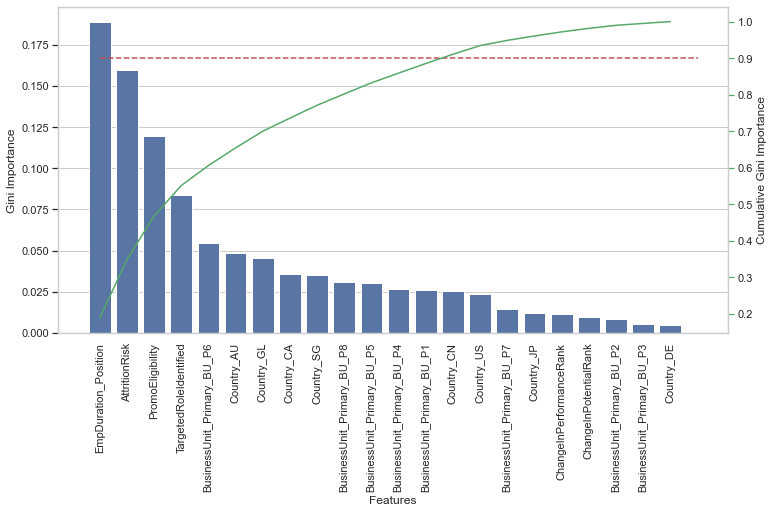

In [25]:
#call gini importance plotting function
plot_gini(fi_pf)

In [26]:
#extract the names of the features that account for 90% Gini Importance
fi_pf_names = list(fi_pf['Feature'][:15])

#create training and test sets with only the important features
x_pf_impt = x_pf[fi_pf_names]
x_pf_impt_train = x_pf_train[fi_pf_names]
x_pf_impt_test = x_pf_test[fi_pf_names]

#train on important features
rf_pf.fit(x_pf_impt_train, y_pf_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=100)

Accuracy: 0.6325088339222615
              precision    recall  f1-score   support

           1       0.07      0.13      0.09        15
           2       0.79      0.73      0.76       210
           3       0.40      0.40      0.40        58

    accuracy                           0.63       283
   macro avg       0.42      0.42      0.42       283
weighted avg       0.67      0.63      0.65       283



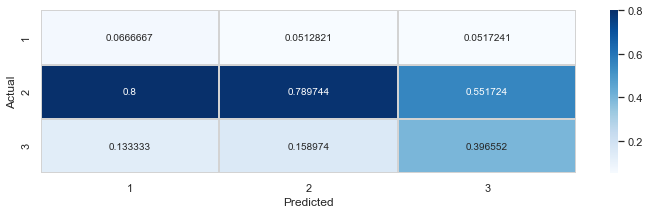

In [27]:
#score the RandomForest model w/ trimmed set of features
score(rf_pf, "Blues", x_pf_impt_test, y_pf_test)

#### Improving model performance: feature selection with SelectFromModel
As a sanity check, we can leverage ScikitLearn's SelectFromModel function to see if we can achieve a better accuracy:

In [28]:
#reset the RandomForest model to fit on the full set of features
rf_pf.fit(x_pf_train, y_pf_train)

#selecting the best features from model based on median
sel = SelectFromModel(rf_pf, threshold = "median")
sel.fit(x_pf_train, y_pf_train)
sel_feat = x_pf_train.columns[(sel.get_support())]

#print the number of features better than median gini
len(sel_feat)

11

In [29]:
#redefine set of features (x) with only selected features
x_pf_sel = x_pf[sel_feat]
x_pf_sel_train = x_pf_train[sel_feat]
x_pf_sel_test = x_pf_test[sel_feat]

#fit the RandomForest model on the selected features
rf_pf.fit(x_pf_sel_train, y_pf_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=100)

Accuracy: 0.6219081272084805
              precision    recall  f1-score   support

           1       0.07      0.13      0.09        15
           2       0.81      0.70      0.75       210
           3       0.38      0.47      0.42        58

    accuracy                           0.62       283
   macro avg       0.42      0.43      0.42       283
weighted avg       0.68      0.62      0.65       283



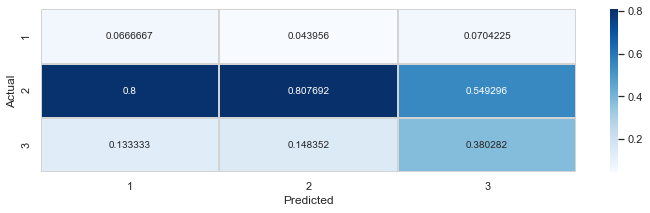

In [30]:
#evaluate the RandomForest model with selected features
score(rf_pf, "Blues", x_pf_sel_test, y_pf_test)

#### Improving model performance: feature selection with Permutation Importance

There are 2 main limitations of impurity-based feature selection above:
- impurity-based importances are biased towards high cardinality features, and
- impurity-based importances are computed on training set statistics and therefore do not reflect the ability of a feature to be useful to make predictions that generalize to the test set (when the model has enough capacity)

As an alternative, we utilize the permutation importances instead. Permutation Importances tests a model by removing each individual feature and replacing it with random noise. In this way, the importance of individual features can be directly compared, and a quantitative threshold can be used to determine feature inclusion.

Permutation Feature Importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

***
You can refer to https://www.kaggle.com/dansbecker/permutation-importance for more information on permutation importance
***

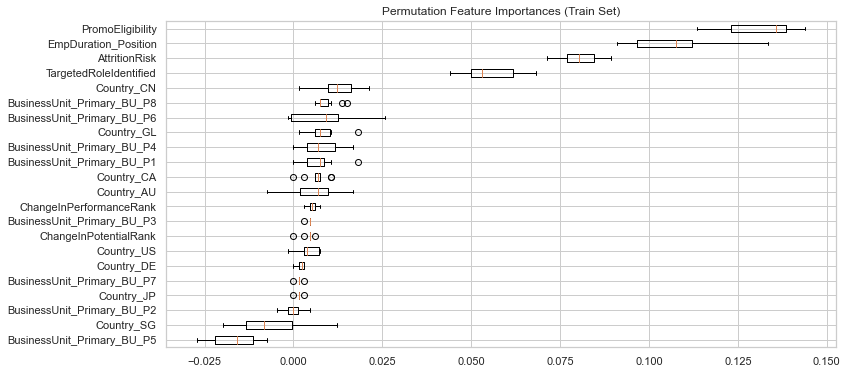

In [31]:
#reset the RandomForest model to fit on the full set of features
rf_pf.fit(x_pf_train, y_pf_train)

#obtain the ranking of each feature from Permutation Importance on the training-set
perm_impt = permutation_importance(rf_pf, x_pf_train, y_pf_train,
                                   n_repeats = 10, random_state = 100, n_jobs = -1)

sorted_idx = perm_impt.importances_mean.argsort()

#plotting the results in a box-plot
fig, ax = plt.subplots(figsize = (12, 6))
ax.boxplot(perm_impt.importances[sorted_idx].T,
           vert = False, labels = x_pf_train.columns[sorted_idx])
ax.set_title("Permutation Feature Importances (Train Set)")
plt.show()

In [32]:
#comparison between impurity-based importances vs. permutation importances on training set
fi_pf_rank = []
x_pf_pmt_rank = []

for i in list(fi_pf['Feature']):
    fi_pf_rank.append(list(fi_pf['Feature']).index(i))
    x_pf_pmt_rank.append(list(x_pf_train.columns[sorted_idx][::-1]).index(i))
    
fi_vs_pmt_pf = {'Feature': list(fi_pf['Feature']),
                'FI Rank': fi_pf_rank,
                'Permutation Rank': x_pf_pmt_rank}

fi_vs_pmt_pf_df = pd.DataFrame(fi_vs_pmt_pf, columns = ['Feature', 'FI Rank', 'Permutation Rank'])
fi_vs_pmt_pf_df.set_index('Feature', inplace = True)
fi_vs_pmt_pf_df

,FI Rank,Permutation Rank
Feature,,
EmpDuration_Position,0,1
AttritionRisk,1,2
PromoEligibility,2,0
TargetedRoleIdentified,3,3
BusinessUnit_Primary_BU_P6,4,6
Country_AU,5,11
Country_GL,6,7
Country_CA,7,10
Country_SG,8,20


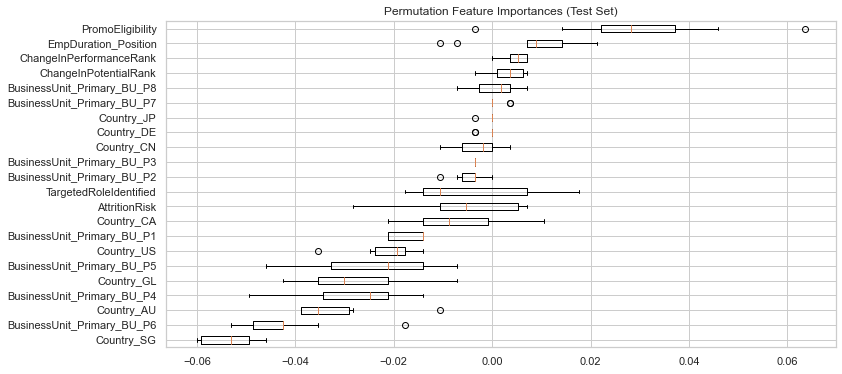

In [33]:
#obtain the ranking of each feature from Permutation Importance on the test-set
perm_impt = permutation_importance(rf_pf, x_pf_test, y_pf_test,
                                   n_repeats = 10, random_state = 100, n_jobs = -1)

sorted_idx = perm_impt.importances_mean.argsort()

#plotting the results in a box-plot
fig, ax = plt.subplots(figsize = (12, 6))
ax.boxplot(perm_impt.importances[sorted_idx].T,
           vert = False, labels = x_pf_test.columns[sorted_idx])
ax.set_title("Permutation Feature Importances (Test Set)")
plt.show()

In [34]:
#create the list of features with Descending importances
pf_pmt_impt_feat = list(x_pf_test.columns[sorted_idx][::-1])

#iteratively add one feature and print the accuracy of the RandomForest model
for i in range(len(pf_pmt_impt_feat)):
    pf_pmt_impt_feat_trial = pf_pmt_impt_feat[0:i+1] #we need to start w/ at least 1 feature
    #define x-train and x-test with iterative list of features
    x_pf_pmt_impt_train = x_pf_train[pf_pmt_impt_feat_trial]
    x_pf_pmt_impt_test = x_pf_test[pf_pmt_impt_feat_trial]
    
    #for the RandomForest model on iterative list of features
    rf_pf.fit(x_pf_pmt_impt_train, y_pf_train)
    #score the fitted model and print accuracy score with # of features
    predictions_trial = rf_pf.predict(x_pf_pmt_impt_test)
    print("No. of Features:", str(i+1), round(sklm.accuracy_score(y_pf_test, predictions_trial), 5))

No. of Features: 1 0.69965
No. of Features: 2 0.66784
No. of Features: 3 0.67845
No. of Features: 4 0.67845
No. of Features: 5 0.4841
No. of Features: 6 0.69965
No. of Features: 7 0.69965
No. of Features: 8 0.69611
No. of Features: 9 0.69258
No. of Features: 10 0.69611
No. of Features: 11 0.70318
No. of Features: 12 0.32862
No. of Features: 13 0.5053
No. of Features: 14 0.5477
No. of Features: 15 0.5371
No. of Features: 16 0.5583
No. of Features: 17 0.60071
No. of Features: 18 0.62544
No. of Features: 19 0.64664
No. of Features: 20 0.64664
No. of Features: 21 0.62544
No. of Features: 22 0.63958


In [35]:
#redefine pf_pmt_impt_feat with top features based on above that gives the highest accuracy score
pf_pmt_impt_feat = pf_pmt_impt_feat[0:11]

#redefine set of features (x) with only the important features
x_pf_pmt = x_pf[pf_pmt_impt_feat]
x_pf_pmt_train = x_pf_train[pf_pmt_impt_feat]
x_pf_pmt_test = x_pf_test[pf_pmt_impt_feat]

Accuracy: 0.7031802120141343
              precision    recall  f1-score   support

           1       0.25      0.07      0.11        15
           2       0.83      0.79      0.81       210
           3       0.41      0.55      0.47        58

    accuracy                           0.70       283
   macro avg       0.50      0.47      0.46       283
weighted avg       0.71      0.70      0.70       283



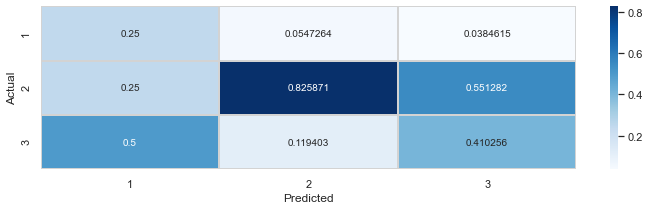

In [36]:
#fit and score the RandomForest model with important features
rf_pf.fit(x_pf_pmt_train, y_pf_train)
score(rf_pf, "Blues", x_pf_pmt_test, y_pf_test)

<mark> **Analysis:**
- **Accuracy** of RandomForest Classifier for 'PerformanceRank_Current' improved to **70%** vs. base RandomForest of **63%**
- Weighted average **Precision** improved to **71%** from **67%**
- Weighted average **Recall** improved to **70%** from **63%**
- Weighted average **F1-Score** improved to **70%** from **65%**

#### Interpreting feature importances
To interpret the importance of the features, we run a simple correlation test against our target to understand the directional impact of each feature:

In [37]:
#identifying the top features from Permutation Importance
features = ['PromoEligibility', 'EmpDuration_Position', 
            'ChangeInPerformanceRank', 'ChangeInPotentialRank']

#create a new dataframe of top features and target variable
features = x_pf[features]
new_df = pd.concat([features, y_pf], axis = 1)

#calculate the correlation
corr = new_df.corr()
corr

,PromoEligibility,EmpDuration_Position,ChangeInPerformanceRank,ChangeInPotentialRank,PerformanceRank_Current
PromoEligibility,1.000000,-0.029716,0.029184,0.029184,0.266376
EmpDuration_Position,-0.029716,1.000000,-0.332624,-0.332624,0.012048
ChangeInPerformanceRank,0.029184,-0.332624,1.000000,1.000000,0.126549
ChangeInPotentialRank,0.029184,-0.332624,1.000000,1.000000,0.126549
PerformanceRank_Current,0.266376,0.012048,0.126549,0.126549,1.000000


<mark> **Analysis:**

From the correlation table above:
- **PromoEligibility:** employees that are eligible for a promotion (i.e. have an ExpectedNextMove in <12 months) tend to have a higher performance rank
- **EmpDuration_Position:** employees that have worked longer in their current position tend to have a higher performance rank (although the correlation is quite low)
- **ChangeInPerformanceRank:** employees that had an improvement in their performance rank tend to have a higher performance rank
- **ChangeInPotentialRank:** employees that had an improvement in their potential rank tend to have a higher performance rank                                          

#### Improving model performance: Hyperparameter tuning with RandomSearch and GridSearch

In [38]:
#creating the grid of parameters for RandomSearch

#number of tress in RandomForest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 10, stop = 110, num = 11)]
max_depth.append(None)
#number of features to consider at every split
max_features = ['log2', 'sqrt']
#minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
#minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#method of selecting samples for training each tree
bootstrap = [True, False]

#create the randomgrid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [39]:
#use RandomGrid to search for best hyperparameters
#randomized-search using 5-fold cross validation
#search across 100 different combinations, and use all available cores
random_search_pf = RandomizedSearchCV(estimator = rf_pf, param_distributions = random_grid,
                                      n_iter = 100, cv = 5, verbose = 1, random_state = 100,
                                      n_jobs = -1)

#fit the randomized-search model
random_search_pf.fit(x_pf_pmt_train, y_pf_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=100),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 

In [40]:
#print the best hyperparameters from RandomGrid
pprint(random_search_pf.best_params_)

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 800}


Accuracy: 0.7137809187279152
              precision    recall  f1-score   support

           1       0.50      0.07      0.12        15
           2       0.84      0.79      0.81       210
           3       0.43      0.62      0.51        58

    accuracy                           0.71       283
   macro avg       0.59      0.49      0.48       283
weighted avg       0.74      0.71      0.71       283



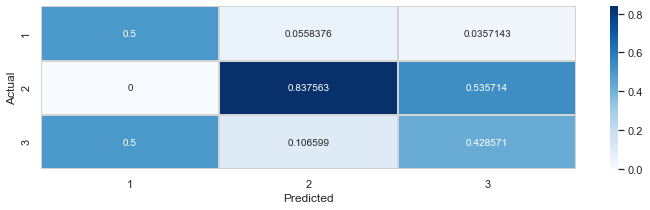

In [41]:
#evaluate the RandomForest model with hyperparameters from RandomSearch
random_grid_pf = random_search_pf.best_estimator_
score(random_grid_pf, "Blues", x_pf_pmt_test, y_pf_test)

Now that we have narrowed down the hyperparameters with RandomizedSearch, we fine-tune the hyperparameters with GridSearch:

In [42]:
#set the parameters to test
param_grid = {'n_estimators': [1000, 1200],
               'max_depth': [80, 90, 100],
               'max_features': ["sqrt"],
               'min_samples_split': [10, 11],
               'min_samples_leaf': [4, 5],
               'bootstrap': [True]}

#start the grid search
grid_search_pf = GridSearchCV(estimator = rf_pf, param_grid = param_grid,
                              cv = 5, n_jobs = -1, verbose = 1, return_train_score = True)

grid_search_pf.fit(x_pf_pmt_train, y_pf_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=100),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100],
                         'max_features': ['sqrt'], 'min_samples_leaf': [4, 5],
                         'min_samples_split': [10, 11],
                         'n_estimators': [1000, 1200]},
             return_train_score=True, verbose=1)

In [43]:
#get the best hyperparameters from GridSearchCV
pprint(grid_search_pf.best_params_)

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 11,
 'n_estimators': 1200}


Accuracy: 0.7137809187279152
              precision    recall  f1-score   support

           1       0.50      0.07      0.12        15
           2       0.84      0.79      0.81       210
           3       0.43      0.62      0.51        58

    accuracy                           0.71       283
   macro avg       0.59      0.49      0.48       283
weighted avg       0.74      0.71      0.71       283



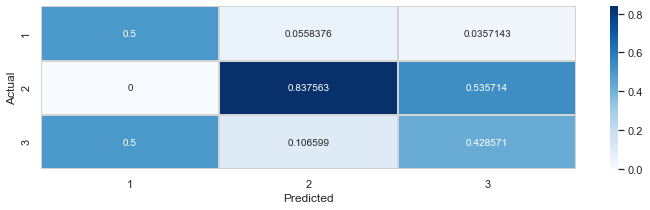

In [44]:
#evaluate the RandomForest model with hyperparameters from GridSearchCV
best_grid_pf = grid_search_pf.best_estimator_
score(best_grid_pf, "Blues", x_pf_pmt_test, y_pf_test)

<mark> **Analysis:**
- **Accuracy** of RandomForest Classifier for 'PerformanceRank_Current' improved to **71%** vs. RandomForest w/ feature selection of **70%**
- Weighted average **Precision** improved to **74%** from **71%**
- Weighted average **Recall** improved to **71%** from **70%**
- Weighted average **F1-Score** improved to **71%** from **70%**

<mark> <span style = "color:blue"> **Key Takeaways:**
- With: (i) a more robust algorithm (RandomForest), (ii) Feature Selection, and (iii) Hyperparameter tuning, we were able to **improve the accuracy of the model by 15%** (from 56% to 71%)

#### Cross Validation: K-fold

To guage the model's ability to generalize to new data, we adopt a resampling method. In short, resampling methods repeat a calculation multiple times using randomly-selected subsets of the complete dataset. In this example, we will adopt a **K-fold Cross Validation** method.

**K-fold Cross Validation** is a widely used resampling method where a dataset is divided into k folds. Each fold contains $\frac{1}{k}$ cases and is created by **Bernoulli random sampling** of the full dataset. A computation is performed on $k-1$ folds of the full dataset. the $k^{th}$ fold is **held back** and is used for testing the result. The computation is performed $k$ times and model parameters are averaged (mean taken) over the results of the $k$ folds. For each iteration, $k-1$ folds are used for training and the $k^{th}$ fold is used for testing.

In [45]:
scores = cross_val_score(best_grid_pf, x_pf_pmt, y_pf, cv = 10)
def print_format(f,x):
    print('Fold %2d %4.3f' % (f, x))
    
def print_cv(scores):
    fold = [x + 1 for x in range(len(scores))]
    print('          Accuracy')
    [print_format(f,x) for f,x in zip(fold,scores)]
    print('-' * 20)
    print('Mean          %4.3f' % (np.mean(scores)))
    print('Std           %4.3f' % (np.std(scores)))
    
print_cv(scores)

          Accuracy
Fold  1 0.358
Fold  2 0.505
Fold  3 0.421
Fold  4 0.638
Fold  5 0.415
Fold  6 0.543
Fold  7 0.532
Fold  8 0.500
Fold  9 0.436
Fold 10 0.383
--------------------
Mean          0.473
Std           0.081


#### Bias-Variance tradeoff with Learning Curves

There are 2 major sources of error when building Machine Learning models: **bias and variance**. In the section below, we attempt to diagnose bias and variance with learning curves.

**Bias:** is the difference between the average prediction of the model and the correct value which we are trying to predict. Models with high bias pays little attention to the training data and oversimplifies the model.

**Variance:** is the variability of the model prediction for a given data point or a value which tells us spread of our data. Models with high variances pays a lot of attention to training data but does not generalize well on data it has not seen before. As a result, such models perform well on training data, but has high error (low accuracy) rates on test data.

In [46]:
#determine the number of rows our training set contains
x_pf_train.shape

(660, 22)

In [47]:
#as our train set has 660 observations, we set the train_sizes for the learning curve below
train_sizes = [1, 50, 100, 300, 500, 600]

#create a plotting function for the learning curve
def learning_curves(estimator, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(estimator, features, target, 
                                                                  train_sizes = train_sizes, cv = cv)
    #get the mean and std of train and validation scores
    train_scores_mean = train_scores.mean(axis = 1)
    train_scores_std = train_scores.std(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    validation_scores_std = validation_scores.std(axis = 1)
    
    #plot the learning curve
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(train_sizes, train_scores_mean, label = "Training Accuracy", marker = "o", color = "r")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = "r")
    ax.plot(train_sizes, validation_scores_mean, label = "Validation Accuracy", marker = "o", color = "g")
    ax.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha = 0.1, color = "g")
    
    plt.ylabel("Accuracy")
    plt.xlabel("Training set size")
    plt.title("Learning curves (Naive Bayes)")
    plt.legend()

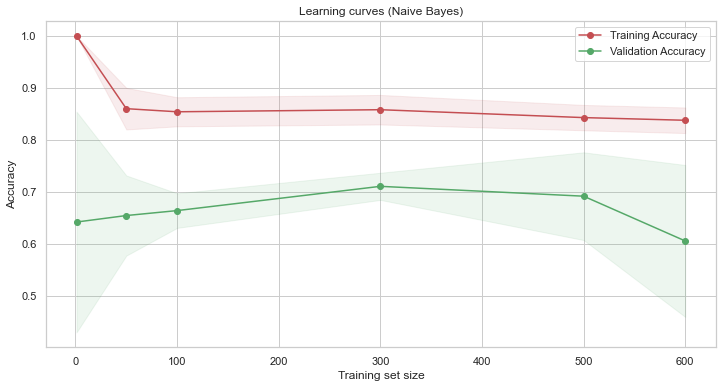

In [48]:
#plotting the baseline RandomForest model
learning_curves(rf_pf, x_pf, y_pf, train_sizes, 5)

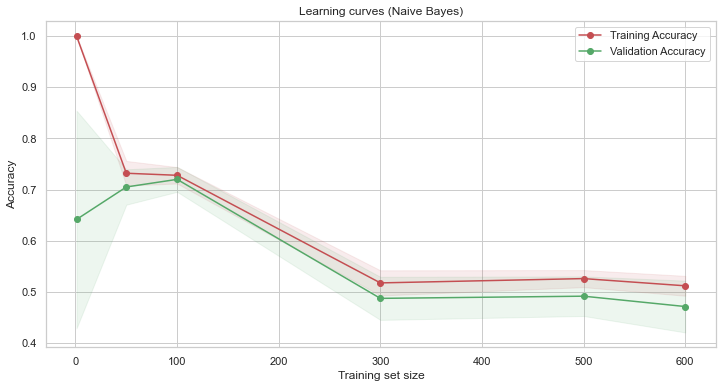

In [49]:
#plotting the best RandomForest model
learning_curves(best_grid_pf, x_pf_pmt, y_pf, train_sizes, 5)

#### Visualizing a DecisionTree within the RandomForest

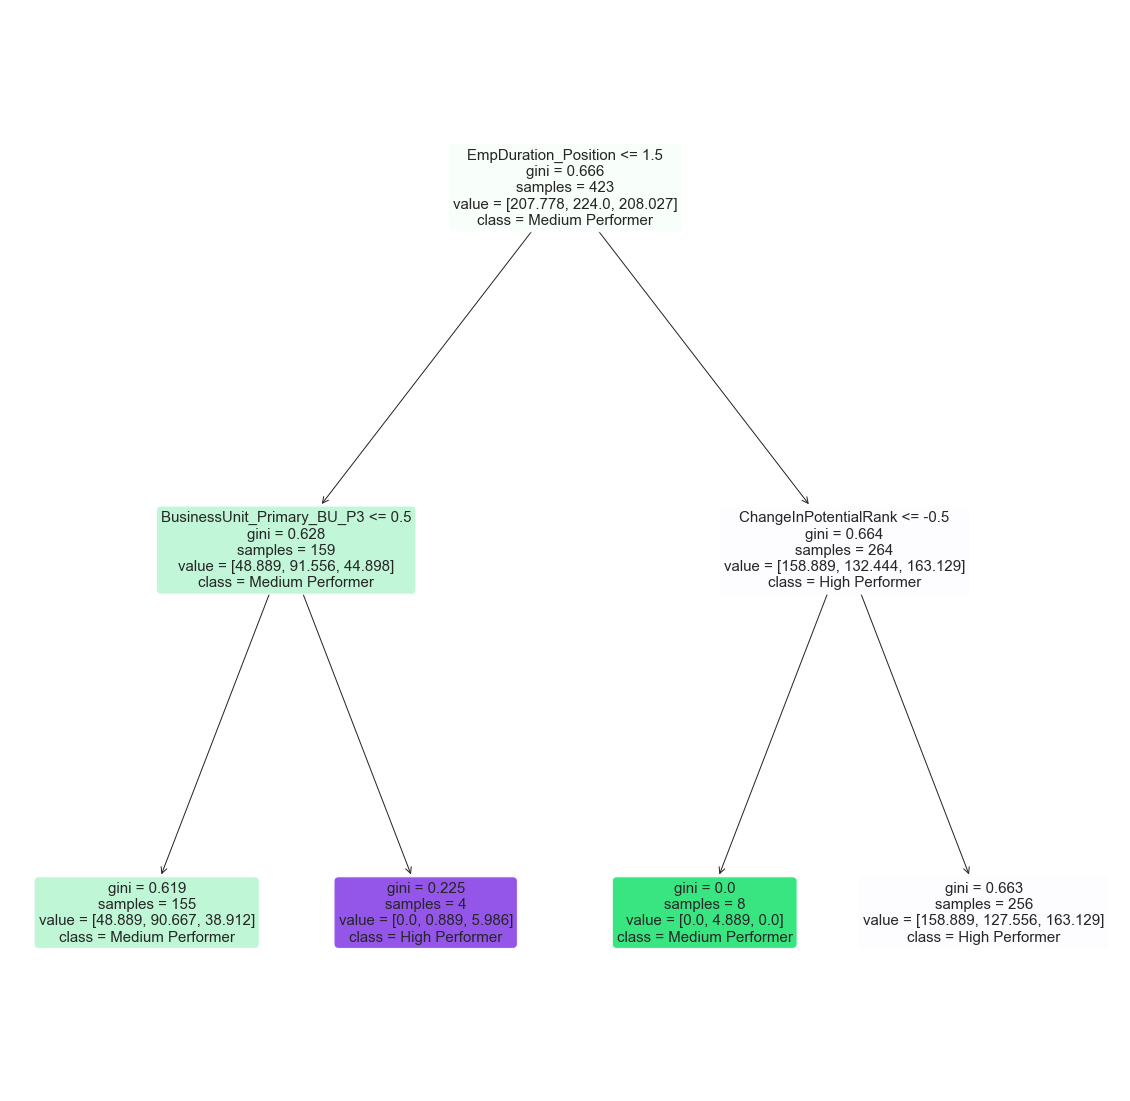

In [50]:
#extract a single tree from RandomForest model
rf_tree_pf = best_grid_pf.estimators_[0]

#build an object to visualize the decision tree
plt.figure(figsize = (20, 20))
tree.plot_tree(rf_tree_pf,
               feature_names = x_pf_pmt.columns.tolist(),
               class_names = ["Low Performer", "Medium Performer", "High Performer"],
               rounded = True, proportion = False,
               filled = True, fontsize = 15)
plt.savefig("PF_tree.png", dpi = 200)
plt.show()

## <mark> Multi-Classifier with 'AttritionRisk' as target

The objective of the model is to predict an employee's risk of attrition. Note that we are unable to predict actual attrition rates unless we have data on employees that have left the company.
    
Similarly, we will start by observing the distribution of our target (label):

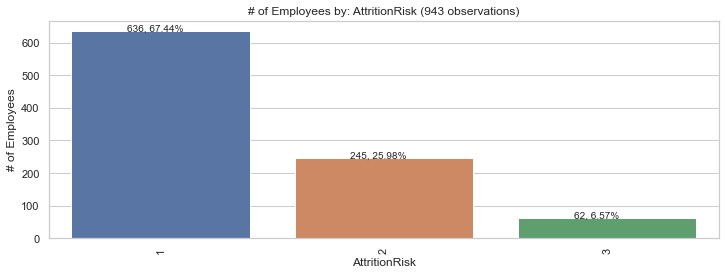

In [51]:
bar_count_perc(df,['AttritionRisk'])

From the chart above, we also see an imbalance in our target towards "1" = "Low" attrition risk. We will account for this imbalance by utilizing 'class_weights = "balanced"' in our classifier algorithms.

#### Data preparation

In [52]:
#define X and Y for ML
x_ar = df[features_ar_initial]
y_ar = df['AttritionRisk']

In [53]:
#perform One-Hot-Encoding for categorical, nominal features
#in this case, these are: 'BusinessUnit_Primary', 'Function', 'Country' and 'JobTitleAgg'
x_ar = pd.get_dummies(data = x_ar)
x_ar

,Pay_Grade,EmpDuration_Company,EmpDuration_Position,Age_Decade,Position_>5Y,Seniority,PromoEligibility,PerformanceRank_Current,PerformanceRank_LastYear,PotentialRank_Current,PotentialRank_LastYear,ChangeInPerformanceRank,ChangeInPotentialRank,BusinessUnit_Primary_BU_P1,BusinessUnit_Primary_BU_P2,BusinessUnit_Primary_BU_P3,BusinessUnit_Primary_BU_P4,BusinessUnit_Primary_BU_P5,BusinessUnit_Primary_BU_P6,BusinessUnit_Primary_BU_P7,BusinessUnit_Primary_BU_P8,Country_AU,Country_CA,Country_CN,Country_DE,Country_GL,Country_JP,Country_SG,Country_US,Gender_Female,Gender_Male,JobTitleAgg_Admin Assistant,JobTitleAgg_Adviser,JobTitleAgg_Analyst,JobTitleAgg_Engineer,JobTitleAgg_Floor Manager,JobTitleAgg_Manager,JobTitleAgg_Research,JobTitleAgg_Supervisor
0,1,15.0,12.5,5,1,1,0,2,2,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
1,1,15.0,12.5,4,1,1,0,2,2,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
2,5,12.5,12.5,6,1,3,0,2,2,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
3,3,2.0,2.0,4,0,2,0,3,3,3,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,2,15.0,2.0,5,0,1,0,3,3,3,3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,4,1.0,1.0,3,0,2,0,2,2,2,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
939,4,15.0,2.0,5,0,2,0,2,2,2,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
940,4,15.0,2.0,4,0,2,1,3,3,3,3,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
941,4,12.5,1.0,3,0,2,1,3,3,3,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0


In [54]:
#train-test-split the dataset, 30% test size
x_ar_train, x_ar_test, y_ar_train, y_ar_test = train_test_split(x_ar, y_ar, test_size = 0.3, random_state = 100)

#checking the shape of the train and test sets
print('x_ar_train shape: ', x_ar_train.shape)
print('y_ar_train shape: ', y_ar_train.shape)
print('x_ar_test shape: ', x_ar_test.shape)
print('y_ar_test shape: ', y_ar_test.shape)

x_ar_train shape:  (660, 39)
y_ar_train shape:  (660,)
x_ar_test shape:  (283, 39)
y_ar_test shape:  (283,)


#### Establishing a baseline: DecisionTree Classifier

In [55]:
#define the DecisionTree model
#as there is class imbalance in the label, we use 'class_weight = "balanced"'
dtree_ar = DecisionTreeClassifier(class_weight = "balanced", random_state = 100)

#train the model
dtree_ar = dtree_ar.fit(x_ar_train, y_ar_train)

Accuracy: 0.5618374558303887
              precision    recall  f1-score   support

           1       0.70      0.69      0.69       183
           2       0.37      0.41      0.39        80
           3       0.00      0.00      0.00        20

    accuracy                           0.56       283
   macro avg       0.36      0.37      0.36       283
weighted avg       0.56      0.56      0.56       283



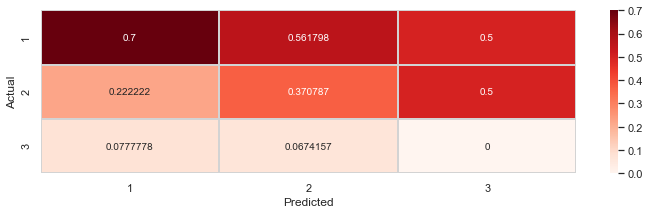

In [56]:
#score the DecisionTree model
score(dtree_ar, "Reds", x_ar_test, y_ar_test)

<mark> **Analysis:**
- **Baseline accuracy** of DecisionTree Classifier for 'AttritionRisk' set at **56%**
- Weighted average **Precision** at **56%**
- Weighted average **Recall** at **56%**
- Weighted average **F1-Score** at **56%**

#### Using a more robust algorithm: RandomForest Classifier

Accuracy: 0.607773851590106
              precision    recall  f1-score   support

           1       0.68      0.82      0.74       183
           2       0.37      0.28      0.32        80
           3       0.00      0.00      0.00        20

    accuracy                           0.61       283
   macro avg       0.35      0.36      0.35       283
weighted avg       0.54      0.61      0.57       283



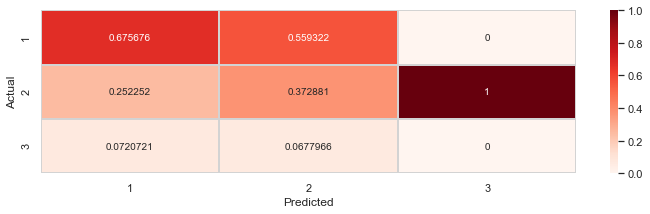

In [57]:
#defining the model
rf_ar = RandomForestClassifier(n_estimators = 100, class_weight = "balanced", 
                               random_state = 100, n_jobs = -1)

#training the model
rf_ar.fit(x_ar_train, y_ar_train)

#evaluate the model
score(rf_ar, "Reds", x_ar_test, y_ar_test)

<mark> **Analysis:**
- **Accuracy** of RandomForest Classifier for 'AttritionRisk' improved to **61%** vs. DecisionTree Classifier's **56%**
- Weighted average **Precision** deproved slightly to **54%** from **56%**
- Weighted average **Recall** improved to **61%** from **56%**
- Weighted average **F1-Score** improved to **57%** from **56%**

#### Improving model performance: feature selection with 90% cumulative Gini Importance

In [58]:
#call gini function and view table of importance
fi_ar = gini90(rf_ar, x_ar_train)

#find number of features for cumulative importance of 90%
#add 1 because Python is 0-indexed
print("Number of features for 90% Gini Importance: ",
      np.where(fi_ar["Cumulative Gini Importances"] > 0.90)[0][0] + 1)

fi_ar

Number of features for 90% Gini Importance:  23


,Feature,Gini Importance,Cumulative Gini Importances
0,EmpDuration_Company,0.127873,0.127873
1,Age_Decade,0.096308,0.224182
2,Pay_Grade,0.086843,0.311025
3,EmpDuration_Position,0.068473,0.379498
4,PromoEligibility,0.065973,0.445471
5,Seniority,0.036452,0.481923
6,Gender_Female,0.032867,0.514789
7,Country_SG,0.029869,0.544659
8,Gender_Male,0.028798,0.573457
9,Country_CA,0.028436,0.601893


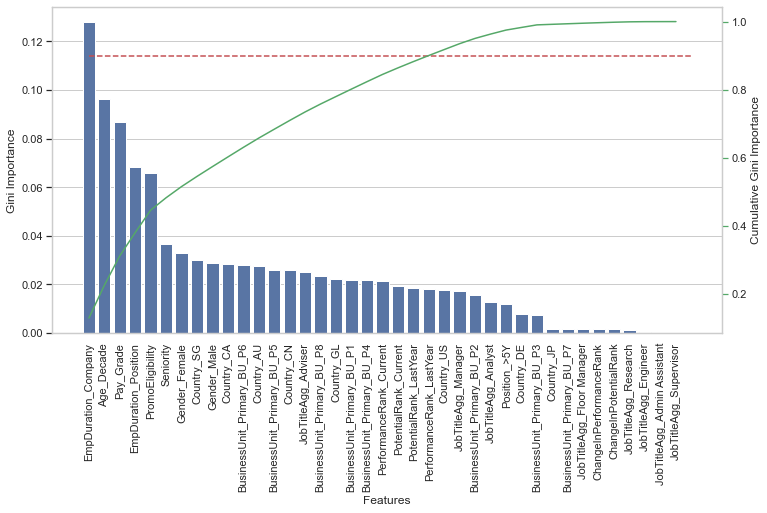

In [59]:
#call gini importance plotting function
plot_gini(fi_ar)

In [60]:
#extract the names of the features that account for 90% Gini Importance
fi_ar_names = list(fi_ar['Feature'][:27])

#create training and test sets with only the important features
x_ar_impt = x_ar[fi_ar_names]
x_ar_impt_train = x_ar_train[fi_ar_names]
x_ar_impt_test = x_ar_test[fi_ar_names]

#train on important features
rf_ar.fit(x_ar_impt_train, y_ar_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=100)

Accuracy: 0.6219081272084805
              precision    recall  f1-score   support

           1       0.68      0.84      0.75       183
           2       0.41      0.28      0.33        80
           3       0.00      0.00      0.00        20

    accuracy                           0.62       283
   macro avg       0.36      0.37      0.36       283
weighted avg       0.56      0.62      0.58       283



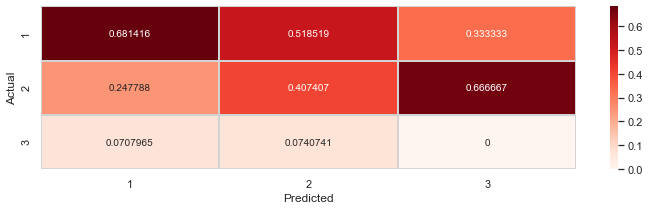

In [61]:
#score the RandomForest model w/ trimmed set of features
score(rf_ar, "Reds", x_ar_impt_test, y_ar_test)

#### Improving model performance: feature selection with SelectFromModel
As a sanity check, we can leverage ScikitLearn's SelectFromModel function to see if we can achieve a better accuracy:

In [62]:
#reset the RandomForest model to fit on the full set of features
rf_ar.fit(x_ar_train, y_ar_train)

#selecting the best features from model based on median
sel = SelectFromModel(rf_ar, threshold = "median")
sel.fit(x_ar_train, y_ar_train)
sel_feat = x_ar_train.columns[(sel.get_support())]

#print the number of features better than median gini
len(sel_feat)

20

In [63]:
#redefine set of features (x) with only selected features
x_ar_sel = x_ar[sel_feat]
x_ar_sel_train = x_ar_train[sel_feat]
x_ar_sel_test = x_ar_test[sel_feat]

#fit the RandomForest model on the selected features
rf_ar.fit(x_ar_sel_train, y_ar_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=100)

Accuracy: 0.5936395759717314
              precision    recall  f1-score   support

           1       0.66      0.82      0.73       183
           2       0.32      0.23      0.26        80
           3       0.00      0.00      0.00        20

    accuracy                           0.59       283
   macro avg       0.33      0.35      0.33       283
weighted avg       0.52      0.59      0.55       283



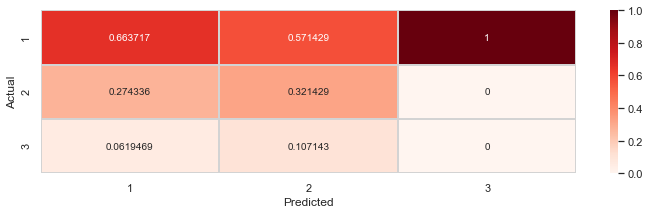

In [64]:
#evaluate the RandomForest model with selected features
score(rf_ar, "Reds", x_ar_sel_test, y_ar_test)

#### Improving model performance: feature selection with Permutation Importance

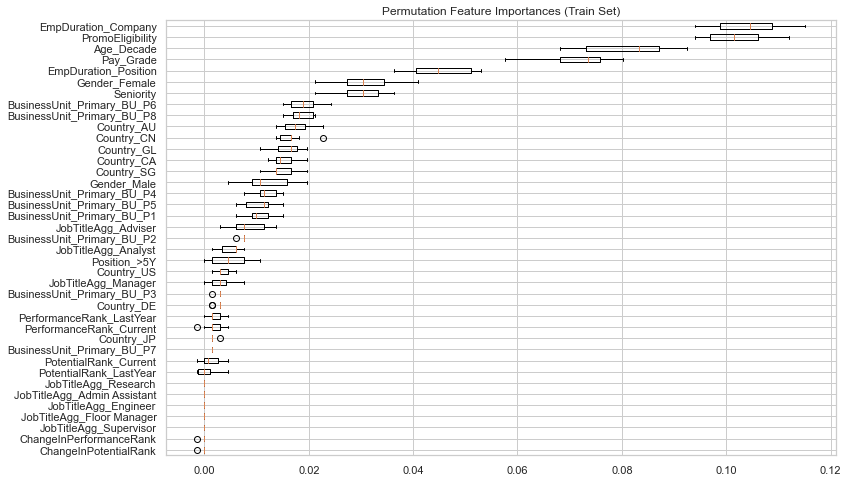

In [65]:
#reset the RandomForest model to fit on the full set of features
rf_ar.fit(x_ar_train, y_ar_train)

#obtain the ranking of each feature from Permutation Importance on the training-set
perm_impt = permutation_importance(rf_ar, x_ar_train, y_ar_train,
                                   n_repeats = 10, random_state = 100, n_jobs = -1)

sorted_idx = perm_impt.importances_mean.argsort()

#plotting the results in a box-plot
fig, ax = plt.subplots(figsize = (12, 8))
ax.boxplot(perm_impt.importances[sorted_idx].T,
           vert = False, labels = x_ar_train.columns[sorted_idx])
ax.set_title("Permutation Feature Importances (Train Set)")
plt.show()

In [66]:
#comparison between impurity-based importances vs. permutation importances on training set
fi_ar_rank = []
x_ar_pmt_rank = []

for i in list(fi_ar['Feature']):
    fi_ar_rank.append(list(fi_ar['Feature']).index(i))
    x_ar_pmt_rank.append(list(x_ar_train.columns[sorted_idx][::-1]).index(i))
    
fi_vs_pmt_ar = {'Feature': list(fi_ar['Feature']),
                'FI Rank': fi_ar_rank,
                'Permutation Rank': x_ar_pmt_rank}

fi_vs_pmt_ar_df = pd.DataFrame(fi_vs_pmt_ar, columns = ['Feature', 'FI Rank', 'Permutation Rank'])
fi_vs_pmt_ar_df.set_index('Feature', inplace = True)
fi_vs_pmt_ar_df

,FI Rank,Permutation Rank
Feature,,
EmpDuration_Company,0,0
Age_Decade,1,2
Pay_Grade,2,3
EmpDuration_Position,3,4
PromoEligibility,4,1
Seniority,5,6
Gender_Female,6,5
Country_SG,7,13
Gender_Male,8,14


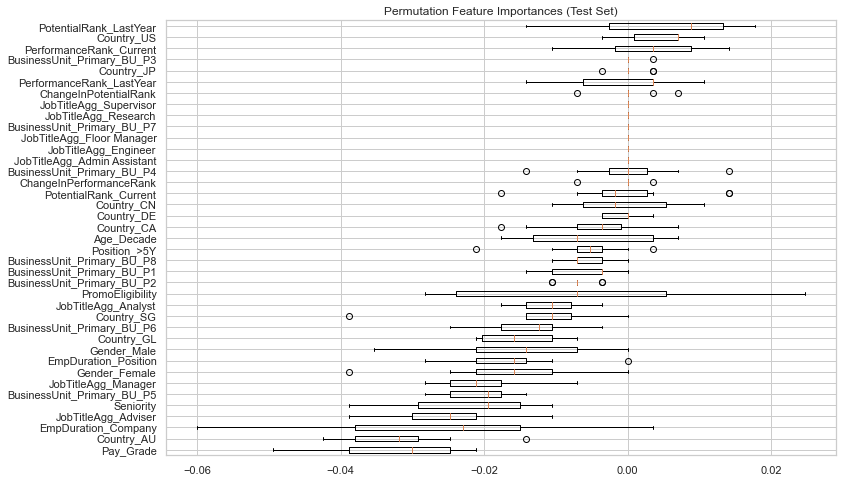

In [67]:
#obtain the ranking of each feature from Permutation Importance on the test-set
perm_impt = permutation_importance(rf_ar, x_ar_test, y_ar_test,
                                   n_repeats = 10, random_state = 100, n_jobs = -1)

sorted_idx = perm_impt.importances_mean.argsort()

#plotting the results in a box-plot
fig, ax = plt.subplots(figsize = (12, 8))
ax.boxplot(perm_impt.importances[sorted_idx].T,
           vert = False, labels = x_ar_test.columns[sorted_idx])
ax.set_title("Permutation Feature Importances (Test Set)")
plt.show()

In [68]:
#create the list of features with Descending importances
ar_pmt_impt_feat = list(x_ar_test.columns[sorted_idx][::-1])

#iteratively add one feature and print the accuracy of the RandomForest model
for i in range(len(ar_pmt_impt_feat)):
    ar_pmt_impt_feat_trial = ar_pmt_impt_feat[0:i+1] #we need to start w/ at least 1 feature
    #define x-train and x-test with iterative list of features
    x_ar_pmt_impt_train = x_ar_train[ar_pmt_impt_feat_trial]
    x_ar_pmt_impt_test = x_ar_test[ar_pmt_impt_feat_trial]
    
    #for the RandomForest model on iterative list of features
    rf_ar.fit(x_ar_pmt_impt_train, y_ar_train)
    #score the fitted model and print accuracy score with # of features
    predictions_trial = rf_ar.predict(x_ar_pmt_impt_test)
    print("No. of Features:", str(i+1), round(sklm.accuracy_score(y_ar_test, predictions_trial), 5))

No. of Features: 1 0.53004
No. of Features: 2 0.5159
No. of Features: 3 0.55124
No. of Features: 4 0.55124
No. of Features: 5 0.5477
No. of Features: 6 0.5477
No. of Features: 7 0.54417
No. of Features: 8 0.54417
No. of Features: 9 0.55124
No. of Features: 10 0.55124
No. of Features: 11 0.55124
No. of Features: 12 0.55124
No. of Features: 13 0.55124
No. of Features: 14 0.54064
No. of Features: 15 0.54417
No. of Features: 16 0.54417
No. of Features: 17 0.58304
No. of Features: 18 0.59011
No. of Features: 19 0.60424
No. of Features: 20 0.49823
No. of Features: 21 0.50177
No. of Features: 22 0.5053
No. of Features: 23 0.5689
No. of Features: 24 0.53357
No. of Features: 25 0.56184
No. of Features: 26 0.59364
No. of Features: 27 0.55477
No. of Features: 28 0.54064
No. of Features: 29 0.53004
No. of Features: 30 0.54417
No. of Features: 31 0.58657
No. of Features: 32 0.5583
No. of Features: 33 0.56537
No. of Features: 34 0.58304
No. of Features: 35 0.61131
No. of Features: 36 0.60777
No. of 

In [69]:
#redefine ar_pmt_impt_feat with top features based on above that gives the highest accuracy score
ar_pmt_impt_feat = ar_pmt_impt_feat[0:37]

#redefine set of features (x) with only the important features
x_ar_pmt = x_ar[ar_pmt_impt_feat]
x_ar_pmt_train = x_ar_train[ar_pmt_impt_feat]
x_ar_pmt_test = x_ar_test[ar_pmt_impt_feat]

Accuracy: 0.6254416961130742
              precision    recall  f1-score   support

           1       0.69      0.84      0.76       183
           2       0.44      0.30      0.36        80
           3       0.00      0.00      0.00        20

    accuracy                           0.63       283
   macro avg       0.38      0.38      0.37       283
weighted avg       0.57      0.63      0.59       283



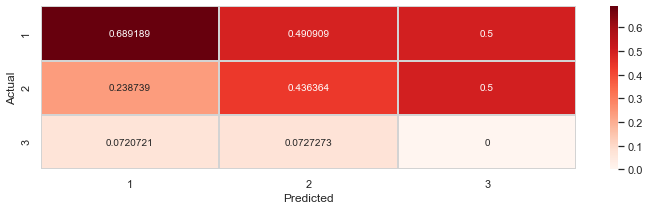

In [70]:
#fit and score the RandomForest model with important features
rf_ar.fit(x_ar_pmt_train, y_ar_train)
score(rf_ar, "Reds", x_ar_pmt_test, y_ar_test)

<mark> **Analysis:**
- **Accuracy** of RandomForest Classifier for 'AttritionRisk' improved to **63%** vs. base RandomForest of **61%**
- Weighted average **Precision** improved to **57%** from **54%**
- Weighted average **Recall** improved to **63%** from **61%**
- Weighted average **F1-Score** improved to **59%** from **57%**

#### Improving model performance: Hyperparameter tuning with RandomSearch and GridSearch

In [71]:
#use RandomGrid to search for best hyperparameters
#randomized-search using 5-fold cross validation
#search across 100 different combinations, and use all available cores
random_search_ar = RandomizedSearchCV(estimator = rf_ar, param_distributions = random_grid,
                                      n_iter = 100, cv = 5, verbose = 2, random_state = 100,
                                      n_jobs = -1)

#fit the randomized-search model
random_search_ar.fit(x_ar_pmt_train, y_ar_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=100),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 

In [72]:
#print the best hyperparameters from RandomGrid
pprint(random_search_ar.best_params_)

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1800}


Accuracy: 0.6254416961130742
              precision    recall  f1-score   support

           1       0.68      0.84      0.75       183
           2       0.43      0.29      0.35        80
           3       0.00      0.00      0.00        20

    accuracy                           0.63       283
   macro avg       0.37      0.38      0.37       283
weighted avg       0.57      0.63      0.59       283



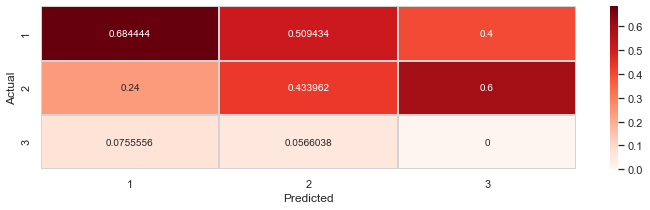

In [73]:
#evaluate the RandomForest model with hyperparameters from RandomSearch
random_grid_ar = random_search_ar.best_estimator_
score(random_grid_ar, "Reds", x_ar_pmt_test, y_ar_test)

Now that we have narrowed down the hyperparameters with RandomizedSearch, we fine-tune the hyperparameters with GridSearch:

In [74]:
#set the parameters to test
param_grid = {'n_estimators': [1800, 1900, 2000],
               'max_depth': [80, 90, 100],
               'max_features': ["sqrt"],
               'min_samples_split': [2, 3, 4],
               'min_samples_leaf': [1, 2, 3],
               'bootstrap': [True]}

#start the grid search
grid_search_ar = GridSearchCV(estimator = rf_ar, param_grid = param_grid,
                              cv = 5, n_jobs = -1, verbose = 1, return_train_score = True)

grid_search_ar.fit(x_ar_pmt_train, y_ar_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=100),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [1800, 1900, 2000]},
             return_train_score=True, verbose=1)

In [75]:
#get the best hyperparameters from GridSearchCV
pprint(grid_search_ar.best_params_)

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1800}


Accuracy: 0.6254416961130742
              precision    recall  f1-score   support

           1       0.68      0.84      0.75       183
           2       0.43      0.29      0.35        80
           3       0.00      0.00      0.00        20

    accuracy                           0.63       283
   macro avg       0.37      0.38      0.37       283
weighted avg       0.57      0.63      0.59       283



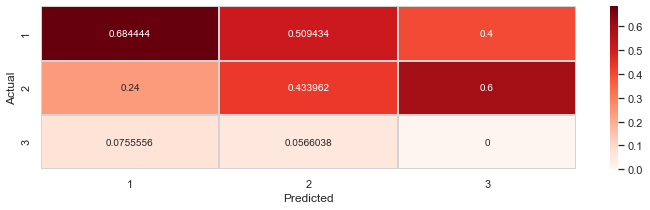

In [76]:
#evaluate the RandomForest model with hyperparameters from GridSearchCV
best_grid_ar = grid_search_ar.best_estimator_
score(best_grid_ar, "Reds", x_ar_pmt_test, y_ar_test)

<mark> **Analysis:**
- **Accuracy** of RandomForest Classifier for 'AttritionRisk' unchanged at **63%** vs. RandomForest w/ selected features of **63%**
- Weighted average **Precision** unchanged at **57%**
- Weighted average **Recall** unchanged at **63%**
- Weighted average **F1-Score** unchanged at **59%**

<mark> <span style = "color:blue"> **Key Takeaways:**
- With: (i) a more robust algorithm (RandomForest), (ii) Feature Selection, and (iii) Hyperparameter tuning, we were able to **improve the accuracy of the model by 7%** (from 56% to 63%)

#### Cross Validation: K-fold

To guage the model's ability to generalize to new data, we adopt a resampling method. In short, resampling methods repeat a calculation multiple times using randomly-selected subsets of the complete dataset. In this example, we will adopt a **K-fold Cross Validation** method.

**K-fold Cross Validation** is a widely used resampling method where a dataset is divided into k folds. Each fold contains $\frac{1}{k}$ cases and is created by **Bernoulli random sampling** of the full dataset. A computation is performed on $k-1$ folds of the full dataset. the $k^{th}$ fold is **held back** and is used for testing the result. The computation is performed $k$ times and model parameters are averaged (mean taken) over the results of the $k$ folds. For each iteration, $k-1$ folds are used for training and the $k^{th}$ fold is used for testing.

In [77]:
scores = cross_val_score(best_grid_ar, x_ar_pmt, y_ar, cv = 10)
   
print_cv(scores)

          Accuracy
Fold  1 0.674
Fold  2 0.600
Fold  3 0.611
Fold  4 0.617
Fold  5 0.617
Fold  6 0.564
Fold  7 0.617
Fold  8 0.596
Fold  9 0.606
Fold 10 0.489
--------------------
Mean          0.599
Std           0.045


#### Bias-Variance tradeoff with Learning Curves

There are 2 major sources of error when building Machine Learning models: **bias and variance**. In the section below, we attempt to diagnose bias and variance with learning curves.

**Bias:** is the difference between the average prediction of the model and the correct value which we are trying to predict. Models with high bias pays little attention to the training data and oversimplifies the model.

**Variance:** is the variability of the model prediction for a given data point or a value which tells us spread of our data. Models with high variances pays a lot of attention to training data but does not generalize well on data it has not seen before. As a result, such models perform well on training data, but has high error (low accuracy) rates on test data.

In [78]:
#determine the number of rows our training set contains
x_ar_train.shape

(660, 39)

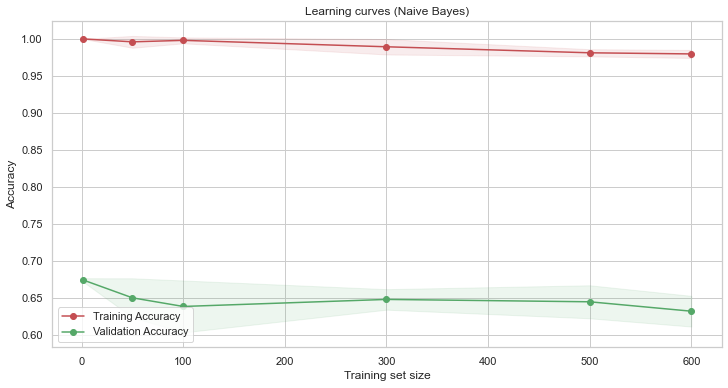

In [79]:
#plotting the baseline RandomForest model
learning_curves(rf_ar, x_ar, y_ar, train_sizes, 5)

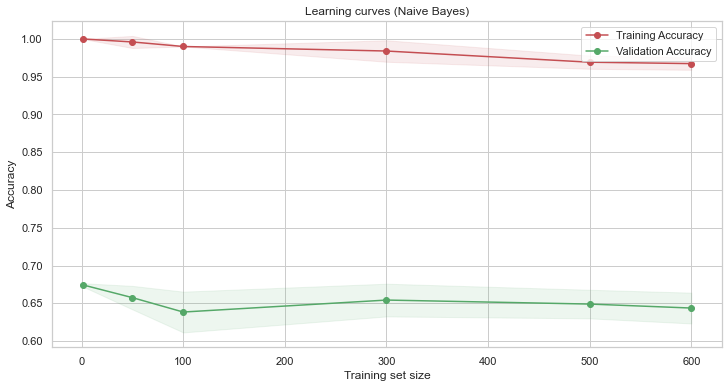

In [80]:
#plotting the best RandomForest model
learning_curves(best_grid_ar, x_ar_pmt, y_ar, train_sizes, 5)

#### Visualizing a DecisionTree within the RandomForest

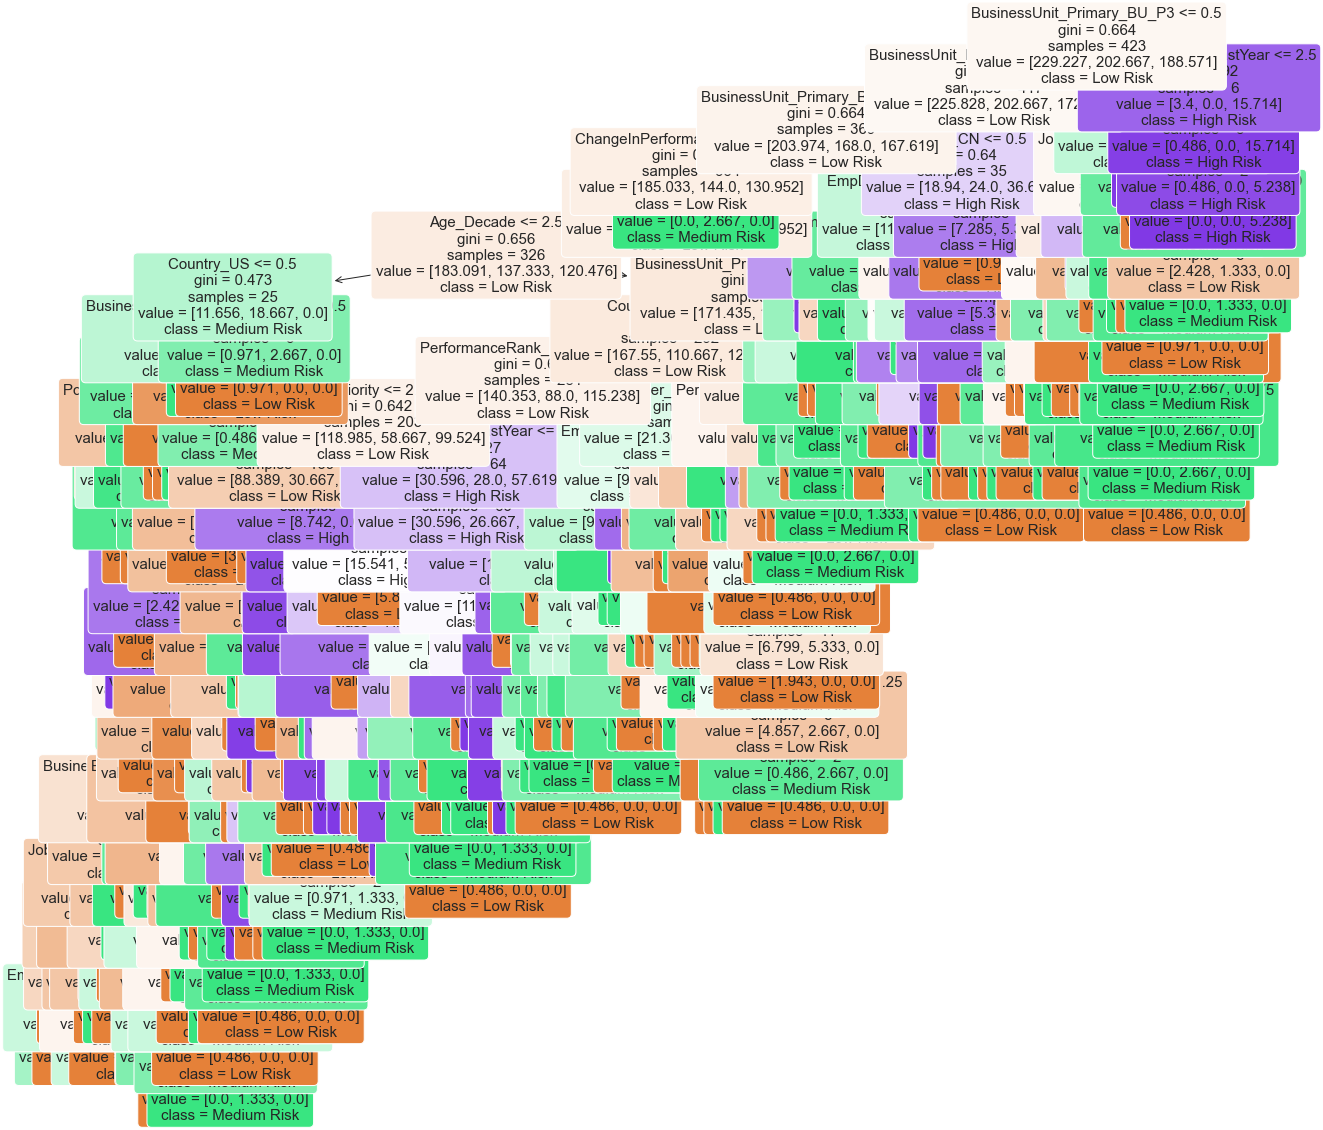

In [81]:
#extract a single tree from RandomForest model
rf_tree_ar = best_grid_ar.estimators_[0]

#build an object to visualize the decision tree
plt.figure(figsize = (20, 20))
tree.plot_tree(rf_tree_ar,
               feature_names = x_ar_pmt.columns.tolist(),
               class_names = ["Low Risk", "Medium Risk", "High Risk"],
               rounded = True, proportion = False,
               filled = True, fontsize = 15)
plt.savefig("AR_tree.png", dpi = 200)
plt.show()